In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.model_selection  import ValidationCurve
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time

In [4]:
# load dataset
data1 = pd.read_csv('./exchange_ratePrice10000000Lot1000000Sqft10000_ptta.csv')
# processing data
data1 = data1[data1['houseprice'] >= 200000][data1['houseprice']<=3000000]
data1 = data1[data1['lot'] < 100000]
# drop some features
data1 = data1.drop(columns = ['_25k', '25k_60k','60k_150k', '150k_',
                              'male', 'female', 'sexRatio',
                              'White', 'African', 'Asian', 
                              'Hawaiian', 'Indian', 'Others',
                              'WhiteRatio','MaleMedianAge',
                              'FemaleMedianAge'])


<ipython-input-4-6206a1792eea>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data1 = data1[data1['houseprice'] >= 200000][data1['houseprice']<=3000000]


In [5]:
data1.shape

(78085, 43)

In [8]:
# XGBoost
startTime = time.time()
X = data1.iloc[:,:-1].values
y= data1.iloc[:,-1].values
X2 = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test =  train_test_split(X2, y,
                     test_size=0.20)
xgb = XGBRegressor(
    learning_rate=0.05,
    n_estimators=500, 
    max_depth=7,
    min_child_weight=2,
    colsample_bytree=0.9,
    subsample=0.8,
    reg_alpha=1,
    reg_lambda=1
)  

xgb.fit(X_train,y_train)
print(time.time() - startTime)

y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

print(time.time()-startTime)
print('測試正確率: %.3f' % xgb.score(X_test, y_test))
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

14.022009372711182
14.134708642959595
測試正確率: 0.896
MSE train: 9301770388.514, test: 22544737325.894
R^2 train: 0.957, test: 0.896


In [9]:
dic = {}
for i in range(len(X_train)):
    if X_train[i][1] not in dic.keys():
        dic[X_train[i][1]] = [1, 0, 0]
    else:
        dic[X_train[i][1]][0] += 1
c = 0
ll = 0
l = []
for i in range(len(y_train)):
    if abs(y_train_pred[i] - y_train[i]) >= y_train[i] * 0.7:
        #print(y_train_pred[i], y_train[i])
        c+=1
        l.append(ll)
        dic[X_train[i][1]][1] += 1
    ll+=1
for i in dic:
    dic[i][2] = dic[i][1]/dic[i][0]
len(l)

326

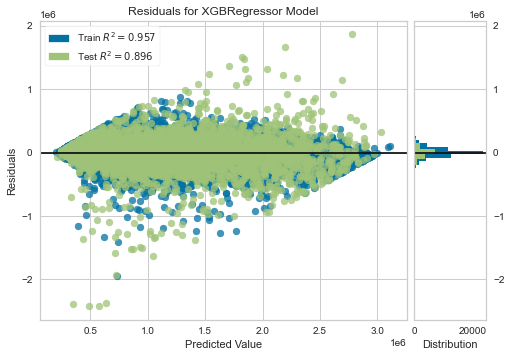

<AxesSubplot:title={'center':'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [10]:
# visualizer繪製殘插圖
visualizer = ResidualsPlot(xgb)
visualizer.fit(X_train,y_train)
visualizer.score(X_test, y_test)
visualizer.show()

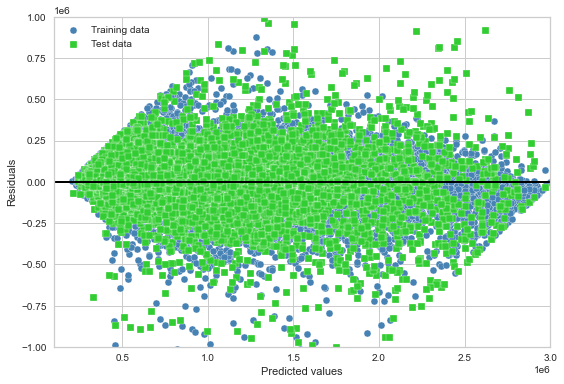

In [11]:
# 第二種殘插圖看喜歡哪個
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=20000000, color='black', lw=2)
plt.ylim([-1000000,1000000])
plt.xlim([100000, 3000000])
plt.tight_layout()

# plt.savefig('demo6_1.png', dpi=300)
plt.show()

In [13]:
cols2=[] # 繪圖用欄位名稱
for i in data1.columns:
    cols2.append(i)
cols2.pop()

'houseprice'

Text(0.5, 1.0, 'RF features importance:')

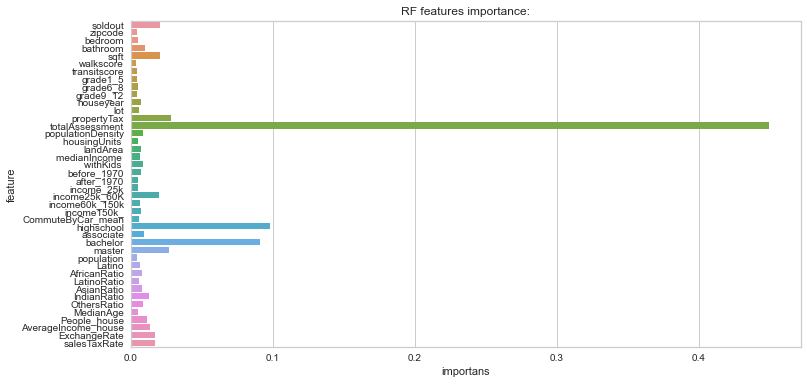

In [14]:
# 重要特徵長條圖
importances = []
for i in xgb.feature_importances_:
    importances.append(i)
# print(importances)
# print(cols2)
feature_dict = {"feature": cols2,"importans":importances}
feature_importance_df =pd.DataFrame(feature_dict)
# feature_importance_df
plt.figure(figsize=(12, 6))
sns.barplot(x="importans", y="feature", data=feature_importance_df)
plt.title('RF features importance:')

<AxesSubplot:>

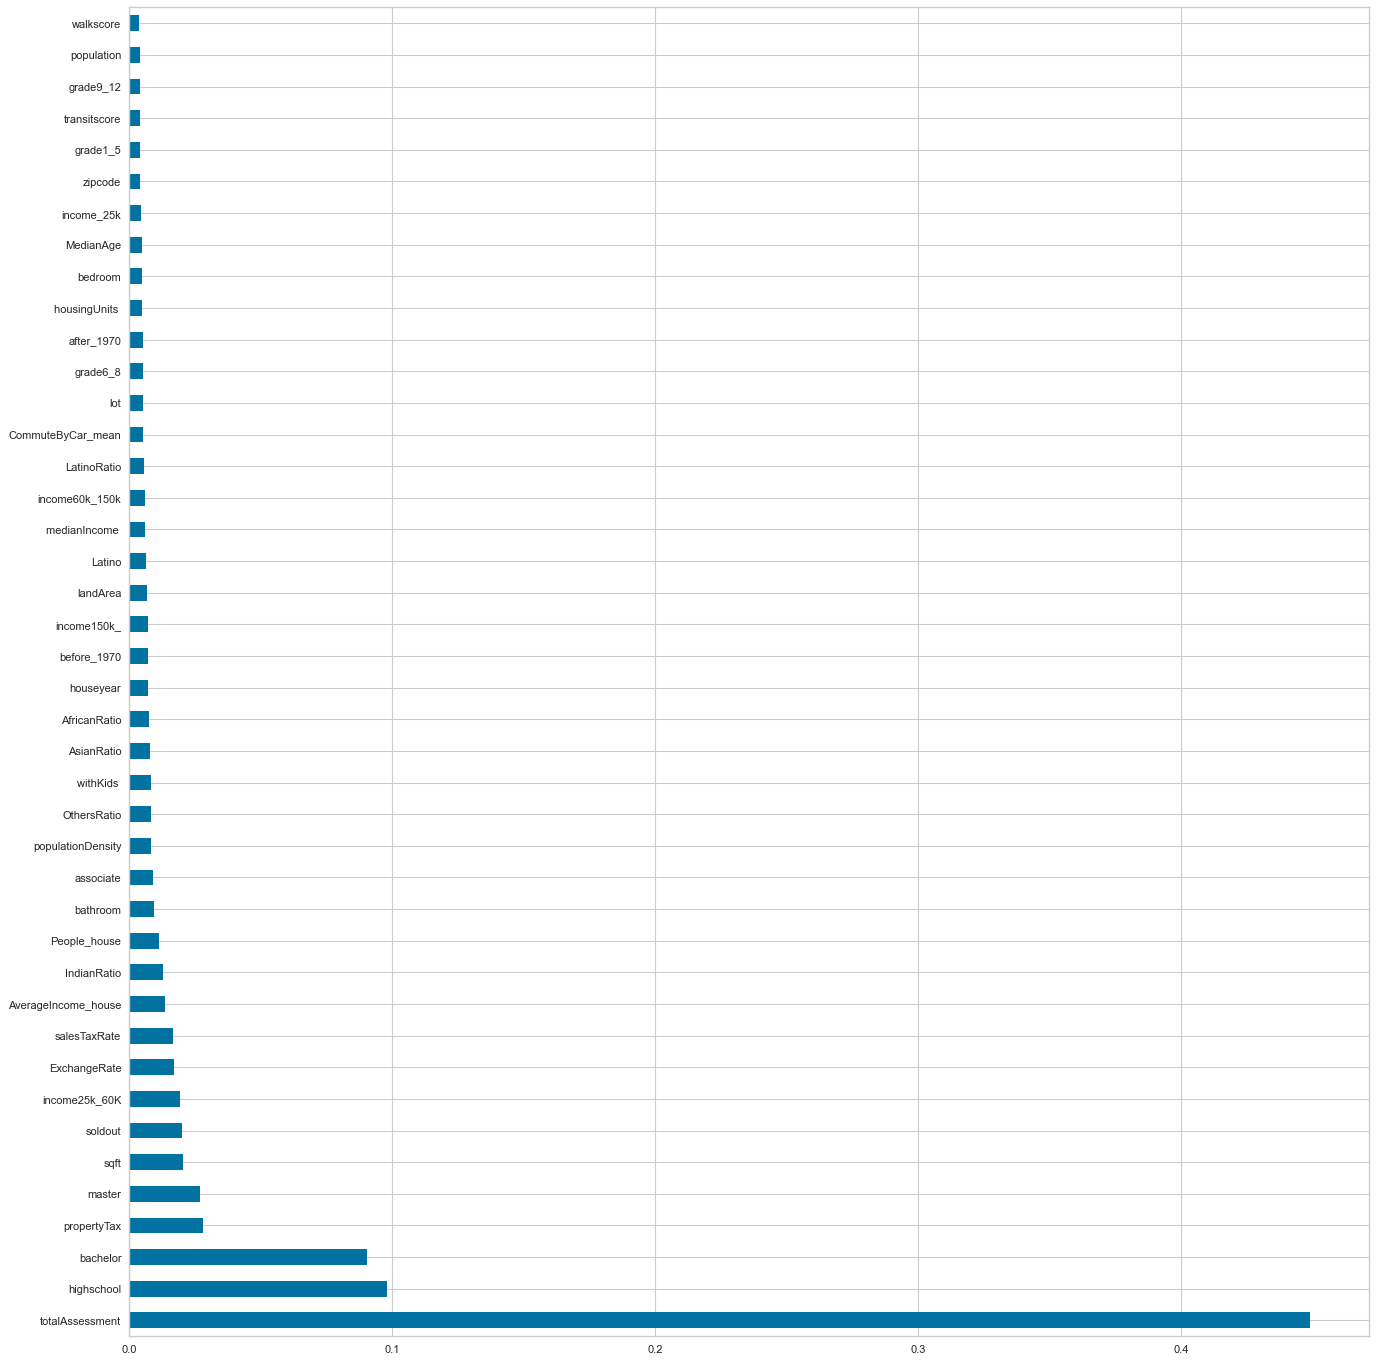

In [15]:
# 兩種圖看喜歡哪一個
plt.figure(num=None, figsize=(20, 22), dpi=80, facecolor='w', edgecolor='k')

feat_importances = pd.Series(xgb.feature_importances_, index= cols2)
feat_importances.nlargest(56).plot(kind='barh')

In [16]:
data1 = pd.read_csv('./exchange_ratePrice10000000Lot1000000Sqft10000_ptta.csv')
data1 = data1[data1['houseprice'] >= 200000][data1['houseprice']<=3000000]
data1 = data1[data1['lot'] < 100000]
data1 = data1.drop(columns = ['_25k', '25k_60k','60k_150k', '150k_',
                              'male', 'female', 'sexRatio',
                              'White', 'African', 'Asian', 'Hawaiian', 'Indian', 'Others',
                              'WhiteRatio','MaleMedianAge',
                              'FemaleMedianAge','totalAssessment'])
X = data1.iloc[:,:-1].values
y= data1.iloc[:,-1].values
X2 = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test =  train_test_split(X2, y,
                     test_size=0.20)

xgb = XGBRegressor(
    learning_rate=0.05,
    n_estimators=475, 
    max_depth=10,
    min_child_weight=1,
    colsample_bytree=0.7,
    subsample=0.9,
    reg_alpha=1.2,
    reg_lambda=1.2,

) 

cv_params = {'n_estimators':[400,425,450,475]}
xgb_cv = GridSearchCV(xgb,param_grid=cv_params, scoring='r2', cv=3, verbose=2, n_jobs=-1)
xgb_cv.fit(X_train,y_train)

y_train_pred = xgb_cv.predict(X_train)
y_test_pred = xgb_cv.predict(X_test)
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))
print(xgb_cv.best_score_)
print(xgb_cv.best_params_)

print("Best score: %0.3f" % xgb_cv.best_score_) # 模型最佳績效
print("Best parameters set:") # 窮舉後的最佳參數
best_parameters = xgb_cv.best_estimator_.get_params()
for param_name in sorted(cv_params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

<ipython-input-16-1b45fa1f34a3>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data1 = data1[data1['houseprice'] >= 200000][data1['houseprice']<=3000000]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:  1.6min remaining:  4.8min
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  1.8min remaining:   21.3s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.8min finished


R^2 train: 0.985, test: 0.909
0.8988878565032904
{'n_estimators': 475}
Best score: 0.899
Best parameters set:
	n_estimators: 475


In [17]:
cv = pd.DataFrame(xgb_cv.cv_results_)
cv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,94.379478,0.270213,0.087934,0.000238,400,{'n_estimators': 400},0.902129,0.892163,0.902008,0.898767,0.004670,4
1,99.794527,0.297083,0.089264,0.001471,425,{'n_estimators': 425},0.902198,0.892197,0.902066,0.898820,0.004684,3
2,103.781720,0.148360,0.089928,0.005025,450,{'n_estimators': 450},0.902221,0.892222,0.902122,0.898855,0.004690,2
3,105.333182,0.183874,0.091595,0.005421,475,{'n_estimators': 475},0.902220,0.892265,0.902178,0.898888,0.004683,1


In [18]:
# kfold
data1 = pd.read_csv('./exchange_ratePrice10000000Lot1000000Sqft10000_ptta.csv')
data1 = data1[data1['houseprice'] >= 200000][data1['houseprice']<=3000000]
data1 = data1[data1['lot'] < 100000]
data1 = data1.drop(columns = ['_25k', '25k_60k','60k_150k', '150k_',
                              'male', 'female', 'sexRatio',
                              'White', 'African', 'Asian', 
                              'Hawaiian', 'Indian', 'Others',
                              'WhiteRatio','MaleMedianAge',
                              'FemaleMedianAge'])
data1['zipcode'] = data1['zipcode'].astype(str)
data1['zipcode'] = data1['zipcode'].astype('category')
X = data1.iloc[:,:-1].values
y= data1.iloc[:,-1].values
X_train, X_test, y_train, y_test =  train_test_split(X, y,
                     test_size=0.20)
xgb = XGBRegressor(
    learning_rate=0.05,
    n_estimators=475, 
    max_depth=10,
    min_child_weight=1,
    colsample_bytree=0.7,
    subsample=0.9,
    reg_alpha=1.2,
    reg_lambda=1.2,

) 
pipe_lr = make_pipeline(StandardScaler(),
                        xgb)

kfold = StratifiedKFold(n_splits=6).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %2d, Acc: %.3f' % (k+1,score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

<ipython-input-18-97bb5d84e4ad>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data1 = data1[data1['houseprice'] >= 200000][data1['houseprice']<=3000000]
C:\Users\Student\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(("The least populated class in y has only %d"


Fold:  1, Acc: 0.905
Fold:  2, Acc: 0.901
Fold:  3, Acc: 0.908
Fold:  4, Acc: 0.913
Fold:  5, Acc: 0.893
Fold:  6, Acc: 0.905

CV accuracy: 0.904 +/- 0.006


In [19]:
# save & load the model
import joblib
joblib.dump(pipe_lr, 'xgboost_model.pkl')
xgb = joblib.load('./xgbmodel.pkl')
X2 = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test =  train_test_split(X2, y,
                     test_size=0.20)
print(xgb.predict(X2[:10]))
print(y[:10])

[478866.38 576788.5  618885.75 576708.6  596466.56 603785.44 635846.7
 600079.8  576529.5  663298.5 ]
[455000. 548000. 685000. 559950. 579950. 570950. 634950. 650000. 624950.
 650965.]
